In [1]:
import sys
import os

galax_module_path = os.path.abspath(os.path.join('..'))
if galax_module_path not in sys.path:
    sys.path.append(galax_module_path)

import galaxies_data as galax
from matplotlib import pyplot as plt
import tensorflow.compat.v2 as tf
import functools
from absl import logging
import pandas as pd
import albumentations as A

In [15]:
def convert(img, target_type_min=0, target_type_max=255, target_type='uint8'):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

In [2]:
def bulid_input_fn(global_batch_size):
    #Build input function.
    #Args:
    #    global_batch_size: Global batch size.
    #Returns:
    #    A function that accepts a dict of params and returns a tuple of images and
    #    features, to be used as the input_fn in TPUEstimator.
    def _input_fn_(input_context):
        #Inner input function
        batch_size = input_context.get_per_replica_batch_size(global_batch_size)
        logging.info('Global batch size: %d', global_batch_size)
        logging.info('Per-replica batch size: %d', batch_size)
        preprocess_fn_pretrain = get_preprocess_fn(True, is_pretrain=True)
        num_classes = 5

        def map_fn(image, label):
            #Produces multiple transformations of the same batch for pretraining
            xs = []
            for _ in range(2):
                xs.append(preprocess_fn_pretrain(image))
            image = tf.concat(xs, -1)
            label = tf.one_hot(label, num_classes)
            return image, label

        logging.info('Using Astro pretrain data')
        dataset = get_data_train()

        if input_context.num_input_pipelines > 1:
            dataset = dataset.shard(input_context.num_input_pipelines, input_context.input_pipeline_id)

        dataset = dataset.shuffle(batch_size * 10)
        dataset = dataset.repeat(-1)
        dataset = dataset.map(map_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
        return dataset

    return _input_fn_

def build_distributed_dataset(batch_size, strategy):
    input_fn = bulid_input_fn(batch_size)
    return strategy.distribute_datasets_from_function(input_fn)

def get_preprocess_fn(is_training, is_pretrain):
    #Get function that accepts an image and returns a preprocessed image
    test_crop=True
    return functools.partial(
        preprocess_image,
        height = 330,
        width= 330,
        color_distort=is_pretrain)


def get_data_train():
    logging.info('Loading Astro pretrain data')
    data_dir = '/home/pedri0/Documents/imagenes_no_clasificadas_desi/'
    def read_images(image_file, label):
        image = tf.io.read_file(data_dir + image_file)
        image = tf.image.decode_jpeg(image, channels = 3)
        return image, label
    
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    df = pd.read_csv('/home/pedri0/Documents/GitHub/Modified-SimCLR/SimCLRTF2/galaxies_train.csv')
    file_paths = df['name'].values
    labels = tf.zeros([df.shape[0]], dtype=tf.int64)
    ds_train = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds_train = ds_train.map(read_images, num_parallel_calls =AUTOTUNE)
    return ds_train

In [373]:
def preprocess_for_train(image, height, width, color_distort, flip=True):
    #Preprocesses the given image for train
    #print(type(image))
    #print(image.shape)
    #image = image.numpy()
    print(image)
    image = tf.py_function(aug_fn, inp=[image, 330], Tout=tf.float32)
    image = tf.reshape(image, [height, width, 3])
    image = tf.clip_by_value(image, 0., 1.)
    return image


####################### Main function ##########################
def preprocess_image(image, height, width, color_distort=True):
    #color_distort: whether to apply the color distortion.
    #Returns A preprocessed image Tensor of range [0,1]
    #image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    #image = preprocess_for_train(image, height, width, color_distort)
    return preprocess_for_train(image, height, width, color_distort)


def transformations():
    transforms = A.Compose([
            #A.Rotate(limit=40),
        
            A.Resize(800,800, p=1.0), #aveces tira error porque hay imagenes de 256x256 al parecer
            A.CenterCrop(400, 400, p=1.0),
            A.Flip(p=1.0),
            A.RandomBrightness(limit=[-0.5,0.2]), #THIS!!!!
            A.ToGray(p=0.2),
            
            #A.JpegCompression(quality_lower=85, quality_upper=100, p=1),
            #A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            #A.RandomContrast(limit=0.2, p=1),
            #A.HorizontalFlip(),
            #A.
        ])
    return transforms

def aug_fn(image, img_size):
    image = image.numpy()
    data = {"image":image}
    transforms = transformations()
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img



In [374]:
strategy = tf.distribute.MirroredStrategy()
ds = build_distributed_dataset(16, strategy)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Tensor("args_0:0", shape=(None, None, 3), dtype=uint8)
Tensor("args_0:0", shape=(None, None, 3), dtype=uint8)


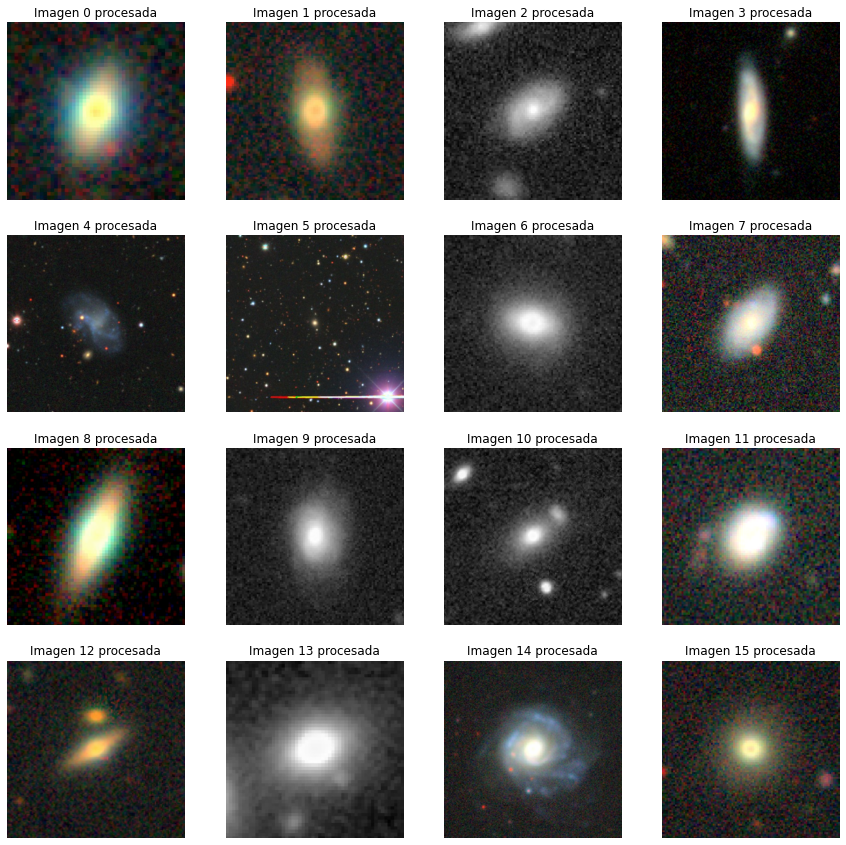

In [375]:
image_batch, label_batch = next(iter(ds))
images_from_0to3=[]
images_from_0to6=[]
for i in range(16):
    img1 = convert(image_batch[i,:,:,:3].numpy())
    img2 = convert(image_batch[i,:,:,3:].numpy())
    images_from_0to3.append(img1)
    images_from_0to6.append(img2)
plt.figure(figsize=(15, 15))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(images_from_0to3[i])
  #label = label_batch[i]
  plt.title('Imagen {} procesada'.format(i))
  plt.axis("off")

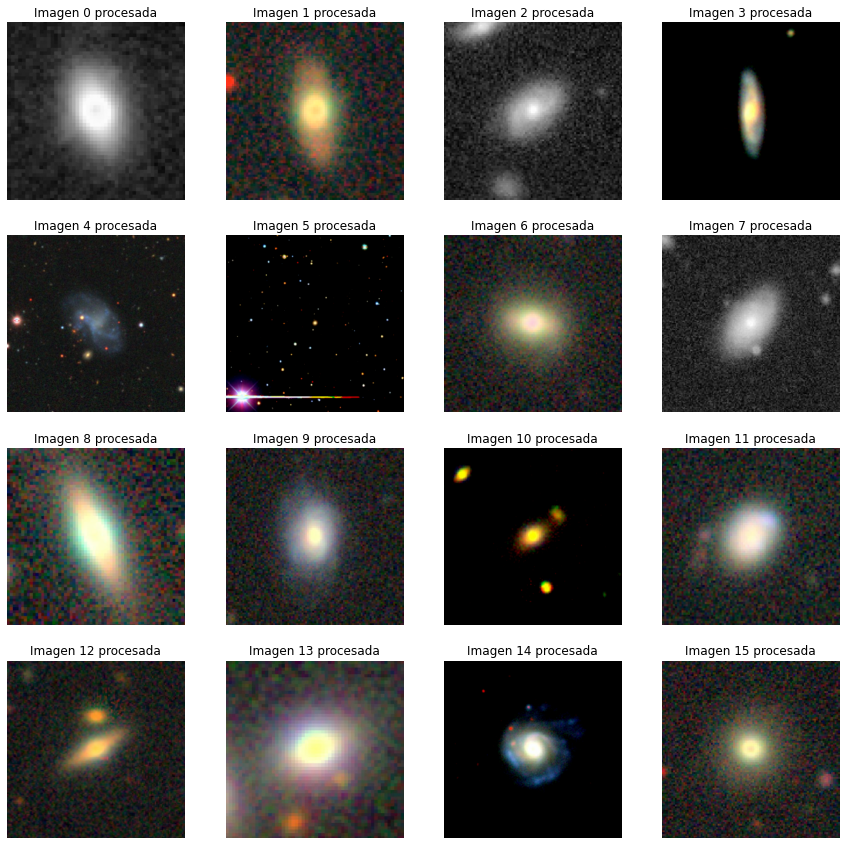

In [376]:
plt.figure(figsize=(15, 15))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(images_from_0to6[i])
  #label = label_batch[i]
  plt.title('Imagen {} procesada'.format(i))
  plt.axis("off")

In [247]:
image_batch

<tf.Tensor: shape=(16, 330, 330, 6), dtype=float32, numpy=
array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          6.05510592e-01, 6.05510592e-01, 6.05510592e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          5.21773934e-01, 5.21773934e-01, 5.21773934e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          5.21535337e-01, 5.21535337e-01, 5.21535337e-01],
         ...,
         [0.00000000e+00, 5.66763878e-02, 0.00000000e+00,
          3.06756496e-01, 3.06756496e-01, 3.06756496e-01],
         [0.00000000e+00, 8.05246755e-02, 0.00000000e+00,
          3.10978651e-01, 3.10978651e-01, 3.10978651e-01],
         [0.00000000e+00, 1.81150496e-01, 0.00000000e+00,
          2.87982136e-01, 2.87982136e-01, 2.87982136e-01]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          5.70534229e-01, 5.70534229e-01, 5.70534229e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          4.88891602e-01, 4.88891602e-01, 4.8889

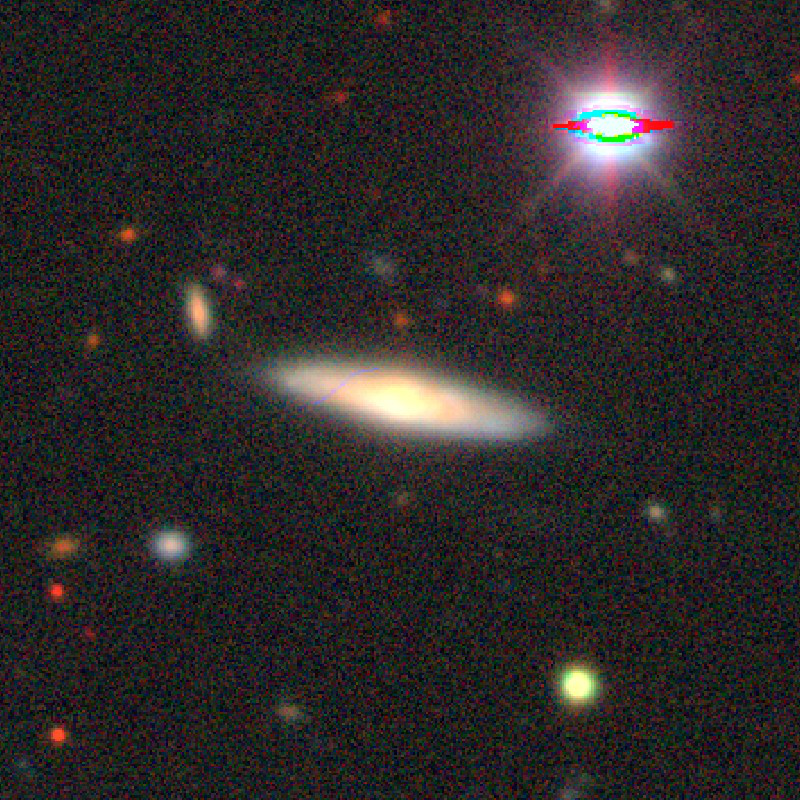

In [233]:
single_image = tf.keras.preprocessing.image.load_img('J000047.88+141639.1.jpg')
single_image

(400, 400, 3)


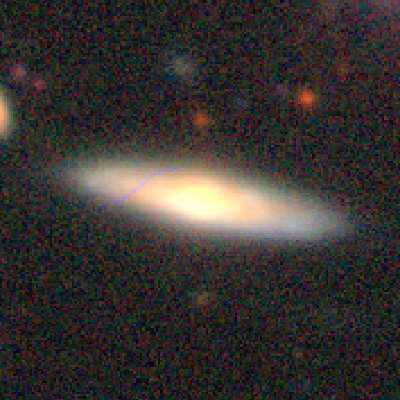

In [234]:
single_image = tf.keras.preprocessing.image.img_to_array(single_image)
transform = A.CenterCrop(400, 400, p=1)(image= single_image)
transform = transform['image']
print(transform.shape)
center = transform
transform = tf.keras.preprocessing.image.array_to_img(transform)
transform

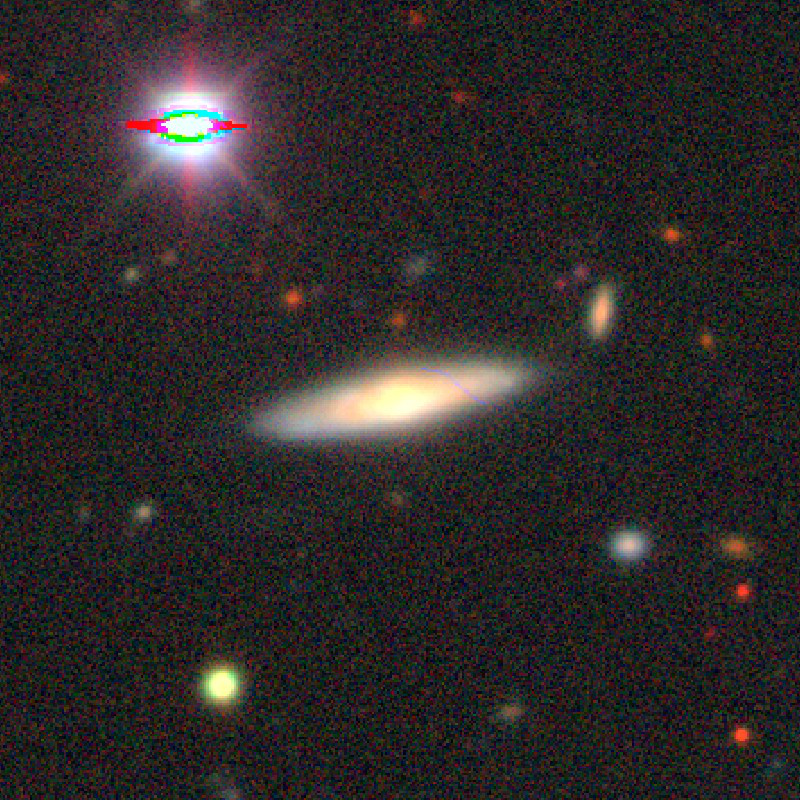

In [71]:
transform = A.Flip(p=0.8)(image= single_image)
transform = transform['image']
transform = tf.keras.preprocessing.image.array_to_img(transform)
transform

(800, 800, 3)


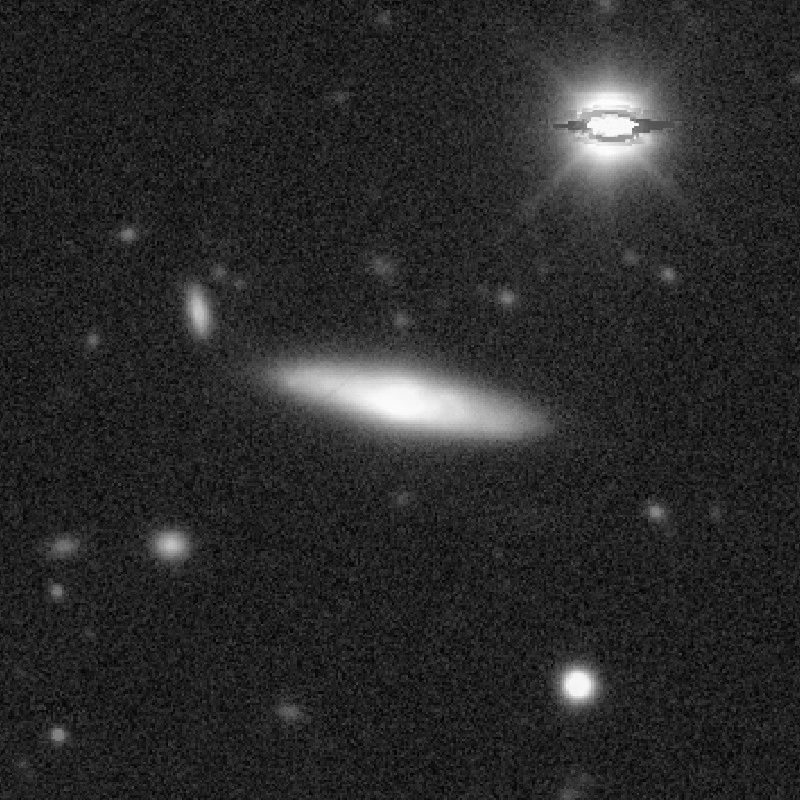

In [73]:
transform = A.ToGray(p=1)(image= single_image)
transform = transform['image']
print(transform.shape)
transform = tf.keras.preprocessing.image.array_to_img(transform)
transform 

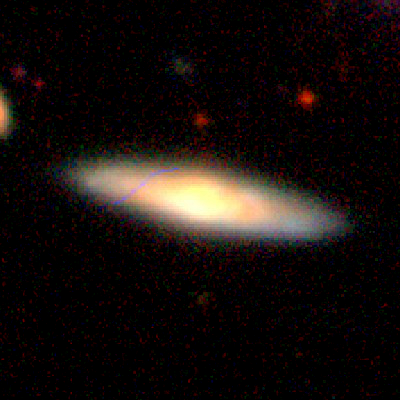

In [539]:
transform = A.RandomBrightnessContrast(brightness_limit=[-0.5,0.2],
                                       contrast_limit=[-0.5,0.2],p=1)(image= center/255)
transform = transform['image']
transform = transform/255
transform = tf.keras.preprocessing.image.array_to_img(transform)
transform

In [181]:
single_image

array([[[56., 45., 62.],
        [24., 23., 31.],
        [10., 25., 28.],
        ...,
        [48., 15., 44.],
        [40., 27., 45.],
        [37., 40., 45.]],

       [[40., 41., 71.],
        [19., 27., 48.],
        [13., 33., 44.],
        ...,
        [51., 18., 37.],
        [42., 25., 35.],
        [42., 36., 36.]],

       [[18., 28., 63.],
        [ 0., 11., 43.],
        [ 0., 11., 37.],
        ...,
        [39., 22., 28.],
        [34., 24., 23.],
        [38., 34., 23.]],

       ...,

       [[34., 49., 52.],
        [16., 62., 59.],
        [ 4., 72., 61.],
        ...,
        [23., 45., 43.],
        [21., 42., 33.],
        [18., 32., 19.]],

       [[ 7., 18., 22.],
        [20., 40., 49.],
        [21., 38., 54.],
        ...,
        [18., 43., 37.],
        [25., 36., 32.],
        [43., 39., 40.]],

       [[11., 11., 19.],
        [43., 34., 55.],
        [53., 18., 58.],
        ...,
        [27., 48., 39.],
        [39., 39., 41.],
        [48., 30., 42.]]